In [1]:
from google.colab import files
uploaded = files.upload()

Saving assignment1.mp4 to assignment1 (1).mp4


In [2]:
!pip install ultralytics opencv-python matplotlib

In [3]:
!nvidia-smi

Tue Jun 24 16:56:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
video_path = "assignment1.mp4"

In [5]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:01<00:00, 49.0MB/s]


In [6]:
import cv2
import json
from collections import defaultdict, Counter

cap = cv2.VideoCapture(video_path)
frame_data = []
class_counter = Counter()
max_diverse_frame = {"index": -1, "diversity": 0}
frame_interval = 5
frame_index = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_index % frame_interval == 0:
        results = model(frame)[0]
        objects = []
        labels_in_frame = set()
        for box in results.boxes:
            cls_id = int(box.cls)
            label = model.names[cls_id]
            conf = float(box.conf)
            xyxy = box.xyxy[0].tolist()
            objects.append({
                "label": label,
                "confidence": round(conf, 3),
                "bbox": [round(c, 1) for c in xyxy]
            })
            class_counter[label] += 1
            labels_in_frame.add(label)
        frame_data.append({
            "frame_index": frame_index,
            "objects": objects
        })
        if len(labels_in_frame) > max_diverse_frame["diversity"]:
            max_diverse_frame = {"index": frame_index, "diversity": len(labels_in_frame)}
    frame_index += 1

cap.release()


0: 384x640 6 persons, 11 cars, 56.7ms
Speed: 7.1ms preprocess, 56.7ms inference, 146.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 11 cars, 1 stop sign, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 13 cars, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11 cars, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 12 cars, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 12 cars, 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11 cars, 13.0ms
Speed: 3.6ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 10 cars, 1

In [7]:
with open("detection_summary.json", "w") as f:
    json.dump(frame_data, f, indent=2)

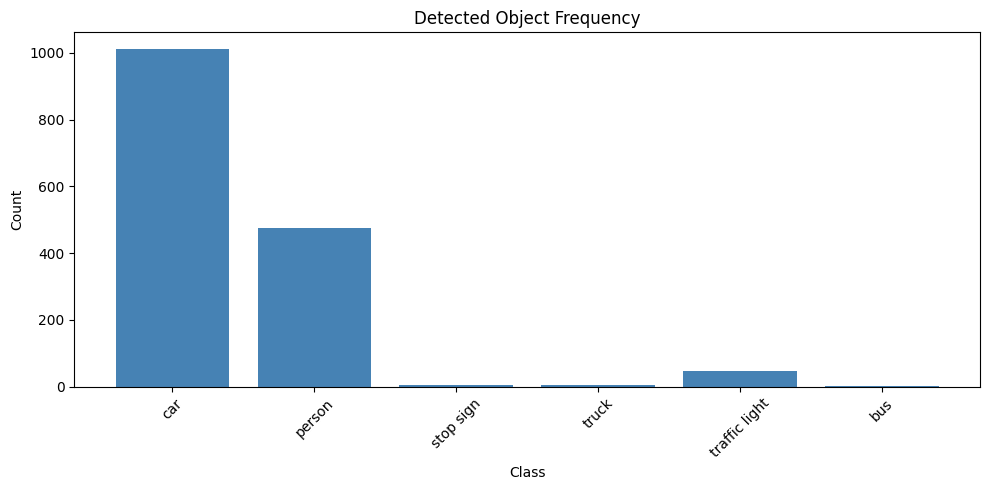

In [8]:
import matplotlib.pyplot as plt

labels, counts = zip(*class_counter.items())
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color="steelblue")
plt.title("Detected Object Frequency")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


0: 384x640 6 persons, 11 cars, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 11 cars, 1 stop sign, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 13 cars, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


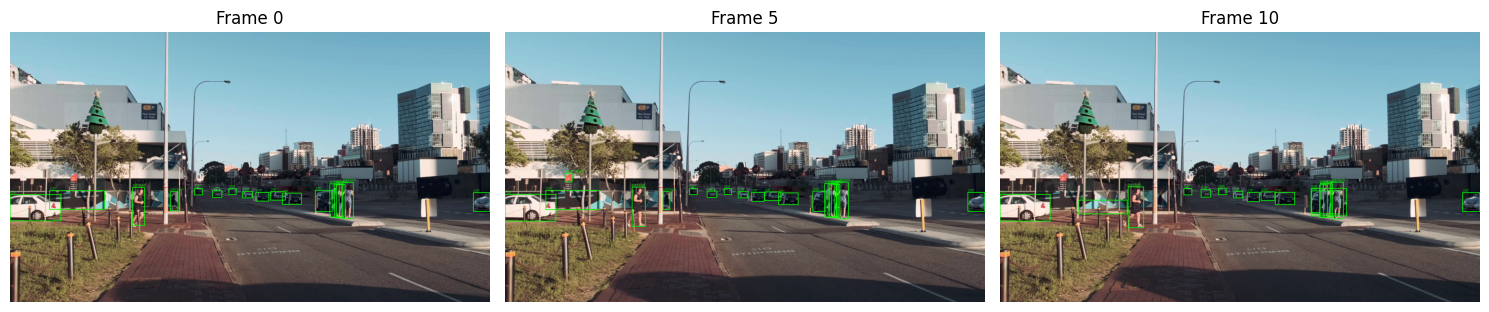

In [9]:
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(video_path)
sample_frames = []
frame_index = 0

while cap.isOpened() and len(sample_frames) < 3:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_index % frame_interval == 0:
        results = model(frame)[0]
        for box in results.boxes:
            cls_id = int(box.cls)
            label = model.names[cls_id]
            xyxy = box.xyxy[0].tolist()
            p1 = (int(xyxy[0]), int(xyxy[1]))
            p2 = (int(xyxy[2]), int(xyxy[3]))
            cv2.rectangle(frame, p1, p2, (0, 255, 0), 2)
            cv2.putText(frame, label, (p1[0], p1[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        sample_frames.append(rgb_frame)
    frame_index += 1

cap.release()

fig, axes = plt.subplots(1, len(sample_frames), figsize=(15, 5))
for idx, img in enumerate(sample_frames):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Frame {idx * frame_interval}")
plt.tight_layout()
plt.show()

In [10]:
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1' if needed
out = cv2.VideoWriter("annotated_output.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

frame_index = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_index % frame_interval == 0:
        results = model(frame)[0]
        for box in results.boxes:
            cls_id = int(box.cls)
            label = model.names[cls_id]
            conf = box.conf.item()
            xyxy = box.xyxy[0].tolist()
            p1 = (int(xyxy[0]), int(xyxy[1]))
            p2 = (int(xyxy[2]), int(xyxy[3]))
            cv2.rectangle(frame, p1, p2, (0, 255, 0), 2)
            cv2.putText(frame, f"{label} {conf:.2f}", (p1[0], p1[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    out.write(frame)
    frame_index += 1

cap.release()
out.release()


0: 384x640 6 persons, 11 cars, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 11 cars, 1 stop sign, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 13 cars, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11 cars, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 12 cars, 13.5ms
Speed: 3.6ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 12 cars, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11 cars, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 10 cars, 10.

In [11]:
print("Total objects per class:")
print(dict(class_counter))

print("\nFrame with maximum class diversity:")
print(max_diverse_frame)

Total objects per class:
{'car': 1011, 'person': 475, 'stop sign': 5, 'truck': 6, 'traffic light': 46, 'bus': 1}

Frame with maximum class diversity:
{'index': 40, 'diversity': 4}
